Main updates with respect to the previous scripts:

- The ground state is calculated by the IBM prototype "vqe".

- The pauli strings are calculated by the "estimator", which returns the expectations of operators.

I'm using the classical simulator "ibmq_qasm_simulator" from the IBM server. The script can directly apply to quantum devices by changing the backend to the quantum ones. I also tried quantum backends, e.g. "ibmq_quito", but it seems take infinitely long time to do vqe with it (I don't know how long, I always lose my patience and quit it.). Only for very simple calculations, can the quantum devices give some results.

In [1]:
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit_nature.algorithms import (GroundStateEigensolver,
                                      NumPyMinimumEigensolverFactory)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from qiskit_nature.circuit.library import UCCSD, HartreeFock
from qiskit.circuit.library import EfficientSU2, RealAmplitudes
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP, NELDER_MEAD
from qiskit import IBMQ, BasicAer, Aer
from qiskit.utils import QuantumInstance
from qiskit.utils.mitigation import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import QasmSimulator
from qiskit import QuantumCircuit, transpile
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliExpectation, CircuitSampler, StateFn, CircuitStateFn
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library import RealAmplitudes
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureMoleculeDriver, ElectronicStructureDriverType)
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper
from qiskit.opflow import TwoQubitReduction, I, X, Y, Z, TaperedPauliSumOp
from qiskit.opflow.primitive_ops import PauliOp, PauliSumOp
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Session
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
from qiskit.algorithms import MinimumEigensolverResult
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.properties.second_quantization.electronic import ParticleNumber
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit import IBMQ
from qiskit_nature.runtime import VQEClient
from qiskit.providers.ibmq import least_busy

import time

In [2]:
IBMQ.load_account()
service = QiskitRuntimeService() #load account
provider = IBMQ.get_provider()
backend = provider.get_backend('ibmq_qasm_simulator')
# backend = provider.get_backend('ibmq_manila')
can_use_runtime = provider.has_service('runtime')
can_use_runtime

True

In [19]:
qdev = provider.backends(simulator=False, operational=True)
least_busy(qdev)

<IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

def callback(nfev, parameters, energy, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)
    
measurement_error_mitigation = True

In [4]:
def get_qubit_op(coordinates):
    
    # Define Molecule
    molecule = Molecule(
        # Coordinates in Angstrom
        geometry=[
            ["H", [coordinates[0], 0.0, 0.0] ],
            ["H", [coordinates[1], 0.0, 0.0] ]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )

    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF)

    # Get properties
    properties = driver.run()
    num_particles = (properties
                        .get_property("ParticleNumber")
                        .num_particles)
    num_spin_orbitals = int(properties
                            .get_property("ParticleNumber")
                            .num_spin_orbitals)
    
    # Define Problem, Use freeze core approximation, remove orbitals.
    problem = ElectronicStructureProblem(
        driver,
        [FreezeCoreTransformer(freeze_core=True)])

    second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles

    mapper = ParityMapper()  # Set Mapper
    hamiltonian = second_q_ops[0]  # Set Hamiltonian
    # Do two qubit reduction
    converter = QubitConverter(mapper,two_qubit_reduction=True)
    reducer = TwoQubitReduction(num_particles)
    qubit_op = converter.convert(hamiltonian)
    qubit_op = reducer.convert(qubit_op)

    return qubit_op, num_particles, num_spin_orbitals, problem, converter

def exact_solver(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result_exact = calc.solve(problem)
    return result_exact

In [5]:
def calc_ground_state(coordinates, shots=1024):
    
    ops, num_part, num_orb, es_problem, converter = get_qubit_op(coordinates)
    result_exact = exact_solver(es_problem,converter)
    init_state = HartreeFock(num_orb, num_part, converter)
    ansatz = UCCSD(converter, num_part, num_orb, initial_state=init_state)
    optimizer = SPSA(200)
    initial_point = np.random.uniform(-np.pi, np.pi, len(ansatz.parameters))
    
    runtime_vqe = VQEClient(ansatz=ansatz,
                         optimizer=optimizer,
                         initial_point=initial_point,
                         provider=provider,
                         backend=backend,
                         shots=shots,
                         measurement_error_mitigation=measurement_error_mitigation)
    
    runtime_result = runtime_vqe.compute_minimum_eigenvalue(ops)

    vqe_sol = runtime_result.optimal_value + es_problem.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
    psi_0 = ansatz.bind_parameters(runtime_result.optimal_point)
    convergence = runtime_result.optimizer_history['energy']

    return vqe_sol, psi_0, convergence

In [21]:
# coordinates = [0,0.7]
# ops, num_part, num_orb, es_problem, converter = get_qubit_op(coordinates)
# result_exact = exact_solver(es_problem,converter)
# init_state = HartreeFock(num_orb, num_part, converter)
# ansatz = UCCSD(converter, num_part, num_orb, initial_state=init_state)
# optimizer = SPSA(200)
# initial_point = np.random.uniform(-np.pi, np.pi, len(ansatz.parameters))

In [22]:
# runtime_vqe = VQEClient(ansatz=ansatz,
#                      optimizer=optimizer,
#                      initial_point=initial_point,
#                      provider=provider,
#                      backend=backend,
#                      shots=1028,
#                      measurement_error_mitigation=measurement_error_mitigation)

In [23]:
# This step will take very long if use real quantum backend.
# runtime_result = runtime_vqe.compute_minimum_eigenvalue(ops)

KeyboardInterrupt: 

In [16]:
Ha = 4.36e-18
angst = 1.0e-10
dR = 0.02 # in Angstrom

def calc_force(coordinates, shots=1024, backend_session="ibmq_qasm_simulator"):
    forces = []
    force_ops = []

    
    for i in range(len(coordinates)):

        #get qubit operators coresponding to H+ (hamiltonian for atomic distances R + dR)
        (qubit_op_plus, num_part_plus, num_orb_plus, problem_plus, converter_plus) = get_qubit_op(coordinates[0:i]+[(coordinates[i]+dR)]+coordinates[i+1:])
    
        #get qubit operators coresponding to H- (hamiltonian for atomic distances R - dR)
        (qubit_op_minus, num_part_minus, num_orb_minus, problem_minus, converter_minus) = get_qubit_op(coordinates[0:i]+[(coordinates[i]-dR)]+coordinates[i+1:])
    
        rep_eng_plus = problem_plus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
        rep_eng_minus = problem_minus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
    
        qubit_op_plus = qubit_op_plus + rep_eng_plus*(I^I) #TODO:number of I's needs to be changed according to number of qubits
        qubit_op_minus = qubit_op_minus + rep_eng_minus*(I^I)
       
        op = (qubit_op_plus - qubit_op_minus).reduce()                                  
        force_ops.append(op)
        
       
        #get the expectation value ¨
        
    # Calculate ground state with runtime vqe
    ops, num_part, num_orb, es_problem, converter = get_qubit_op(coordinates)

    result_exact = exact_solver(es_problem,converter)
    init_state = HartreeFock(num_orb, num_part, converter)
    ansatz = UCCSD(converter, num_part, num_orb, initial_state=init_state)
    initial_point = np.random.uniform(-np.pi, np.pi, len(ansatz.parameters))
    optimizer = SPSA(200)

    runtime_vqe = VQEClient(ansatz=ansatz,
                     optimizer=optimizer,
                     initial_point=initial_point,
                     provider=provider,
                     backend=backend,
                     shots=shots,
                     measurement_error_mitigation=measurement_error_mitigation)

    runtime_result = runtime_vqe.compute_minimum_eigenvalue(ops)

#     vqe_sol = runtime_result.optimal_value + es_problem.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
    psi_0 = ansatz.bind_parameters(runtime_result.optimal_point)
#     convergence = runtime_result.optimizer_history['energy']
    
    # Calculate the expectations of the Pauli strings with estimator
    with Session(service=service, backend=backend_session):
        estimator = Estimator()
        estimator.set_options(shots=shots)
        force = estimator.run(circuits=[psi_0]*len(force_ops), observables=force_ops)
        f = force.result().values.real
        
        # in the dimension of nN to avoid small values.
    
    return f*Ha*(1/(2*dR*angst))

In [7]:
def calc_force_and_cov(coordinates, PauliArray= np.array([]), shots=1024, diag=False, backend_session="ibmq_qasm_simulator"):
    ''' Calculates the force and covariance matrix at given coordinates, and an array of all
    Pauli operators that are in the support of the relevant observables, denoted as pauli_op_array 
    inside of the function. Once this support has been calculated, it can be reused, and thus one can also 
    pass it as argument, denoted PauliArray.
    '''
    num_coord = len(coordinates)    

    forces = np.zeros(num_coord)
    force_ops = []
    force_op_coeffs = [] # array with dictionaries containing Pauli coefficients
    
    #get force component operators and decomposition (without the 1/(2*dR) factor, for numerical reasons) 
    for i in range(num_coord):
        
        #get qubit operators coresponding to H+ (hamiltonian for atomic distances R + dR)
        (qubit_op_plus, num_part_plus, num_orb_plus, problem_plus, converter_plus) = get_qubit_op(coordinates[0:i]+[(coordinates[i]+dR)]+coordinates[i+1:])

        #get qubit operators coresponding to H- (hamiltonian for atomic distances R - dR)
        (qubit_op_minus, num_part_minus, num_orb_minus, problem_minus, converter_minus) = get_qubit_op(coordinates[0:i]+[(coordinates[i]-dR)]+coordinates[i+1:])

        rep_eng_plus = problem_plus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
        rep_eng_minus  = problem_minus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
        
        qubit_op_plus = qubit_op_plus + rep_eng_plus*(I^I) #TODO:number of I's needs to be changed according to number of qubits
        qubit_op_minus = qubit_op_minus + rep_eng_minus*(I^I)
       
        op = (qubit_op_minus - qubit_op_plus).reduce()                  
        op_list = op.primitive.to_list() #list containing Pauli operators in support and corresponding coeffs
                
        force_ops.append(op)
        force_op_coeffs.append(op_list)
        
        if i == 0:  #we need two Pauli Ops to calculate the product and their support
            P1 = op
    
    if PauliArray.size == 0:
        
        pauli_op_set = {'II'} #Could not initialize empty set for some reason
        # construct set of PauliOp products that we need to calculate

        for (PauliString,coeff) in force_op_coeffs[0]:
            pauli_op_set.add(PauliString)

        #to get set of necessary PauliOp products:
            P_prod = (P1@P1).reduce()
            P_list = P_prod.primitive.to_list()

            for (PauliString,coeff) in P_list:
                pauli_op_set.add(PauliString)
                
        pauli_op_array = np.array(list(pauli_op_set))
                
    else: pauli_op_array = PauliArray
        
    # transform pauli strings into the form of PauliSumOp to measure them in the estimator session
    paulis_ops = []
    for PauliString in pauli_op_array:
        paulis_ops.append(PauliSumOp(SparsePauliOp(PauliString)))
        
    # Now we calculate the expectation values of all the relevant PauliOps   
    exp_dict = {} # dictionary with relevant expectation values

    # Calculate ground state with runtime vqe
    ops, num_part, num_orb, es_problem, converter = get_qubit_op(coordinates)

    result_exact = exact_solver(es_problem,converter)
    init_state = HartreeFock(num_orb, num_part, converter)
    ansatz = UCCSD(converter, num_part, num_orb, initial_state=init_state)
    initial_point = np.random.uniform(-np.pi, np.pi, len(ansatz.parameters))
    optimizer = SPSA(200)

    runtime_vqe = VQEClient(ansatz=ansatz,
                     optimizer=optimizer,
                     initial_point=initial_point,
                     provider=provider,
                     backend=backend,
                     shots=shots,
                     measurement_error_mitigation=measurement_error_mitigation)

    runtime_result = runtime_vqe.compute_minimum_eigenvalue(ops)

#     vqe_sol = runtime_result.optimal_value + es_problem.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
    psi_0 = ansatz.bind_parameters(runtime_result.optimal_point)
#     convergence = runtime_result.optimizer_history['energy']

    # Calculate the expectations of the Pauli strings with estimator
    with Session(service=service, backend=backend_session):
        estimator = Estimator()
        estimator.set_options(shots=shots)
        paulis_exp = estimator.run(circuits=[psi_0]*len(pauli_op_array), observables=paulis_ops)
                
    exp_dict = {} # dictionary with relevant expectation values

    for i in range(len(pauli_op_array)):

        pauli_string = pauli_op_array[i]
        Obs = PauliOp(Pauli(pauli_string))
        E = paulis_exp.result().values.real[i]

        exp_dict[pauli_string] = E
            
    for i in range(len(coordinates)):
        for (pauli_op,coeff) in force_op_coeffs[i]:
                forces[i] += coeff.real*exp_dict[pauli_op]
                
    COV = np.zeros((num_coord,num_coord)) #force covariance matrix, without some multiplicative factors. 
    COV_diag = np.zeros((num_coord,num_coord)) #only diagonal terms. 
    
    for i in range(num_coord):
        for j in range(i,num_coord):
            Pij = (force_ops[i]@force_ops[j]).reduce()
            Pij_list = Pij.primitive.to_list()
            
            #add product expectation 
            for (pauli_string,coeff) in Pij_list:
                COV[i,j] += coeff.real*exp_dict[pauli_string]
            #subtract 
            COV[i,j] -= forces[i]*forces[j]
            
            #since COV is symmetric
            if i < j:
                COV[j,i] = COV[i,j] 
        COV_diag[i,i] = COV[i,i]
        
    if diag == True:
        COV = COV_diag
  
    return forces*Ha*(1/(2*dR*angst)),COV*(Ha*(1/(2*dR*angst)))**2, pauli_op_array

In [8]:
from tqdm import tqdm #to show progress

femto = 1.0e-15
angst = 1.0e-10
u = 1.67e-27
#mass of particle1 (H)
mass_0 = u
#mass of particle2 (H)
mass_1 = u
mass = [mass_0, mass_1]
#time step of integrator
dt = 0.2*femto
#initial velocity of atoms
v_init = [0, 0]
#initial positions of atoms
init_pos = [0, 0.6]

#integrator timesteps
times = np.arange(0*femto, 20.0*femto, dt)

#k_B*T in Joule
k_B = 1.38065e-23
T = 420
k_T = k_B*T
#delta factor
delta = 8*dt

In [17]:
def microcanonical(init_pos, v_init=v_init, mass=mass, shots=1024, times=times, backend_session="ibmq_qasm_simulator"):
    #coordinate array
    coords = [init_pos]
    momentum = [[mass[0]/u*v_init[0]/angst*femto, mass[1]/u*v_init[1]/angst*femto]]
    forces = []
    
    for time in tqdm(times, desc='Progress: '):
        r = coords[-1]
        if time == 0:
            f = calc_force(coords[-1], shots=shots, backend_session=backend_session)
            forces.append(f)
            r_next = np.array(r)*angst + np.array(v_init)*dt - 0.5*np.array(f)/np.array(mass)*(dt*dt)
            v_next = (r_next - np.array(r)*angst)/dt
            
        else:
            f = calc_force(coords[-1], shots=shots, backend_session=backend_session)
            forces.append(f)
            r_prev = coords[-2]
            r_next = 2*np.array(r)*angst - np.array(r_prev)*angst - np.array(f)/np.array(mass)*(dt*dt)
            v_next = (r_next - np.array(r)*angst)/dt

        coords.append([r_next[0]/angst, r_next[1]/angst])
        momentum.append([mass[0]/u*v_next[0]/angst*femto, mass[1]/u*v_next[1]/angst*femto])

    return coords, momentum, forces

def canonical(init_pos, v_init=v_init, mass=mass, shots=1024, diag=False, times=times, backend_session="ibmq_qasm_simulator"):
    coords = [init_pos]
    momentum = [[mass[0]/u*v_init[0]/angst*femto, mass[1]/u*v_init[1]/angst*femto]]
    force = []
    
    for time in tqdm(times, desc='Progress: '):
        r = coords[-1]
        if time == 0:
            if diag == False:
                (forces,COV,pauli_op_array) = calc_force_and_cov(coords[-1], shots=shots, backend_session=backend_session)
            else:
                (forces,COV,pauli_op_array) = calc_force_and_cov(coords[-1], shots=shots, diag=True, backend_session=backend_session)
            f0 = forces[0]
            f1 = forces[1]
            force.append(forces)
            v_next = v_init - delta/(2*k_T*np.sqrt(mass_0*mass_1))*np.matmul(COV,v_init)/shots*dt + np.concatenate((f0/mass_0,f1/mass_1),axis=None)*dt      
            r_next = (np.array(r)*angst + dt*v_next)/angst

        else:
            if diag == False:
                (forces,COV,_) = calc_force_and_cov(coords[-1], PauliArray=pauli_op_array, shots=shots, backend_session=backend_session)
            else:
                (forces,COV,_) = calc_force_and_cov(coords[-1], PauliArray=pauli_op_array, shots=shots, diag=True, backend_session=backend_session)
            f0 = forces[0]
            f1 = forces[1]    
            force.append(forces)
            v_next += - delta/(2*k_T*np.sqrt(mass_0*mass_1))*np.matmul(COV,v_next)/shots*dt + np.concatenate((f0/mass_0,f1/mass_1),axis=None)*dt
            r_next = (np.array(r)*angst + dt*v_next)/angst

        coords.append([r_next[0], r_next[1]])
        momentum.append([mass[0]/u*v_next[0]/angst*femto, mass[1]/u*v_next[1]/angst*femto])
    
    return coords, momentum, force

In [23]:
times = np.arange(0*femto, 20.0*femto, dt)

(coords_langevin, momentum_langevin, force_langevin) = canonical(init_pos=init_pos, shots=1024, times=times)

Progress: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [43:18<00:00, 25.98s/it]


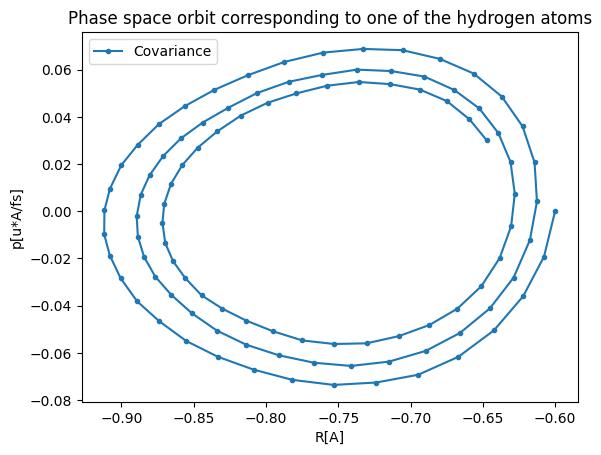

In [24]:
coords_langevin_np = np.array(coords_langevin)
momentum_langevin_np = np.array(momentum_langevin)
dist_langevin = coords_langevin_np[:,0]-coords_langevin_np[:,1]
p_langevin = momentum_langevin_np[:,0]

plt.plot(dist_langevin, p_langevin, marker='.', label="Covariance")
plt.title('Phase space orbit corresponding to one of the hydrogen atoms')
plt.xlabel("R[A]")
plt.ylabel("p[u*A/fs]")
plt.legend()
plt.show()

In [19]:
times = np.arange(0*femto, 20.0*femto, dt)

(coords_verlet, momentum_verlet, force_verlet) = microcanonical(init_pos=init_pos, shots=1024, times=times)

Progress: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [41:41<00:00, 25.02s/it]


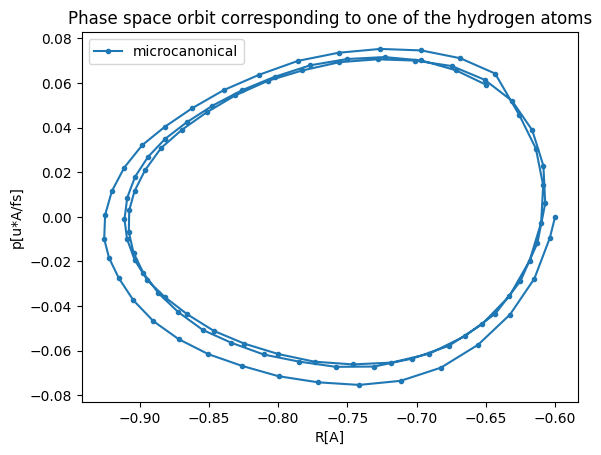

In [22]:
coords_verlet_np = np.array(coords_verlet)
momentum_verlet_np = np.array(momentum_verlet)
dist_verlet = coords_verlet_np[:,0]-coords_verlet_np[:,1]
p_verlet = momentum_verlet_np[:,0]

plt.plot(dist_verlet, p_verlet, marker='.', label="microcanonical")
plt.title('Phase space orbit corresponding to one of the hydrogen atoms')
plt.xlabel("R[A]")
plt.ylabel("p[u*A/fs]")
plt.legend()
plt.show()